## Importing libraries

In [2]:
import os
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AdditiveAttention
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

## Loading the data

In [3]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [4]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open('best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## The LSTM-CNN model with tuned hyperparameters and attention layer

In [22]:
def model_build(params, X_train, X_val, y_test, y_val):
    # extracting the parameters
    lstm_units = params['lstm_units']
    dense_1_units = params['dense_1_units']
    dense_2_units = params['dense_2_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']

    # Model architecture
    input_layer = Input(shape=(20,))
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                          output_dim=embeddings_GloVe.shape[1],
                          weights=[embeddings_GloVe],
                          trainable=False)(input_layer)
    
    spatial_dropout = SpatialDropout1D(0.2)(embedding)
    conv1d = Conv1D(filters=64, kernel_size=1, activation='relu')(spatial_dropout)
    dense = Dense(dense_1_units, activation='relu')(conv1d)
    max_pooling = MaxPooling1D()(dense)
    lstm = Bidirectional(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid',
                              recurrent_dropout=0.1, return_sequences=True))(max_pooling)
    
    #Adding a attention layer for potential improvements
    #Using scaling to normalize the values and prevent extreme values 
    attention_layer = AdditiveAttention(use_scale=True)
    attention_output = attention_layer([lstm, lstm], return_attention_scores=False)
    attention_output = GlobalAveragePooling1D()(attention_output)
    
    dense = Dense(dense_2_units, activation='relu')(attention_output)
    dropout = Dropout(dropout_rate)(dense)
    output_layer = Dense(num_classes, activation='sigmoid')(dropout)

    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model

In [28]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

model = model_build(params, X_train, X_val, y_train, y_val)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Epoch 1/20
282/282 [==============================] - 15s 23ms/step - loss: 0.6063 - accuracy: 0.6741 - val_loss: 0.5750 - val_accuracy: 0.7241
Epoch 2/20
282/282 [==============================] - 6s 21ms/step - loss: 0.5534 - accuracy: 0.7214 - val_loss: 0.5378 - val_accuracy: 0.7360
Epoch 3/20
282/282 [==============================] - 5s 20ms/step - loss: 0.5296 - accuracy: 0.7398 - val_loss: 0.5311 - val_accuracy: 0.7453
Epoch 4/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5095 - accuracy: 0.7491 - val_loss: 0.5140 - val_accuracy: 0.7505
Epoch 5/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5005 - accuracy: 0.7517 - val_loss: 0.5237 - val_accuracy: 0.7287
Epoch 6/20
282/282 [==============================] - 6s 23ms/step - loss: 0.4856 - accuracy: 0.7616 - val_loss: 0.5083 - val_accuracy: 0.7635
Epoch 7/20
282/282 [==============================] - 6s 20ms/step - loss: 0.4752 - accuracy: 0.7665 - val_loss: 0.5217 - val_accuracy: 0.745

In [31]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 20, 100)              2223500   ['input_5[0][0]']             
                                                                                                  
 spatial_dropout1d_4 (Spati  (None, 20, 100)              0         ['embedding_4[0][0]']         
 alDropout1D)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)           (None, 20, 64)               6464      ['spatial_dropout1d_4[0]

## Evaluation of the model

61/61 [==============================] - 1s 8ms/step - loss: 0.5209 - accuracy: 0.7657
Test Loss: 0.5208818912506104
Test Accuracy: 0.7656816840171814


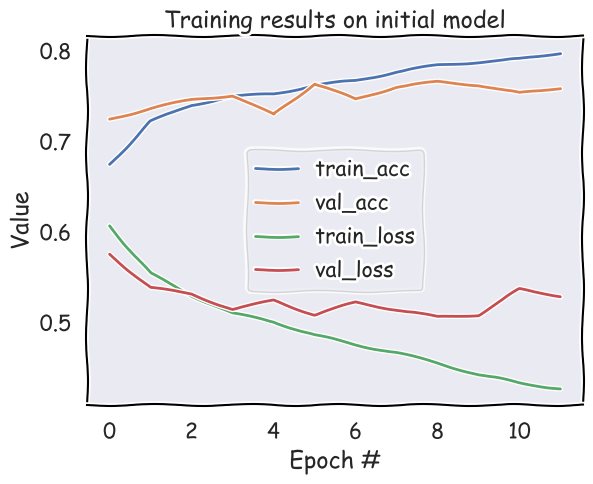

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

## Classification metrics

31/31 [==============================] - 2s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.64       665
           1       0.81      0.84      0.83      1264

    accuracy                           0.77      1929
   macro avg       0.74      0.73      0.73      1929
weighted avg       0.76      0.77      0.76      1929

Accuracy: 0.7656817003628823
Recall: 0.8449367088607594
Precision: 0.8066465256797583
F1 Score: 0.8253477588871716


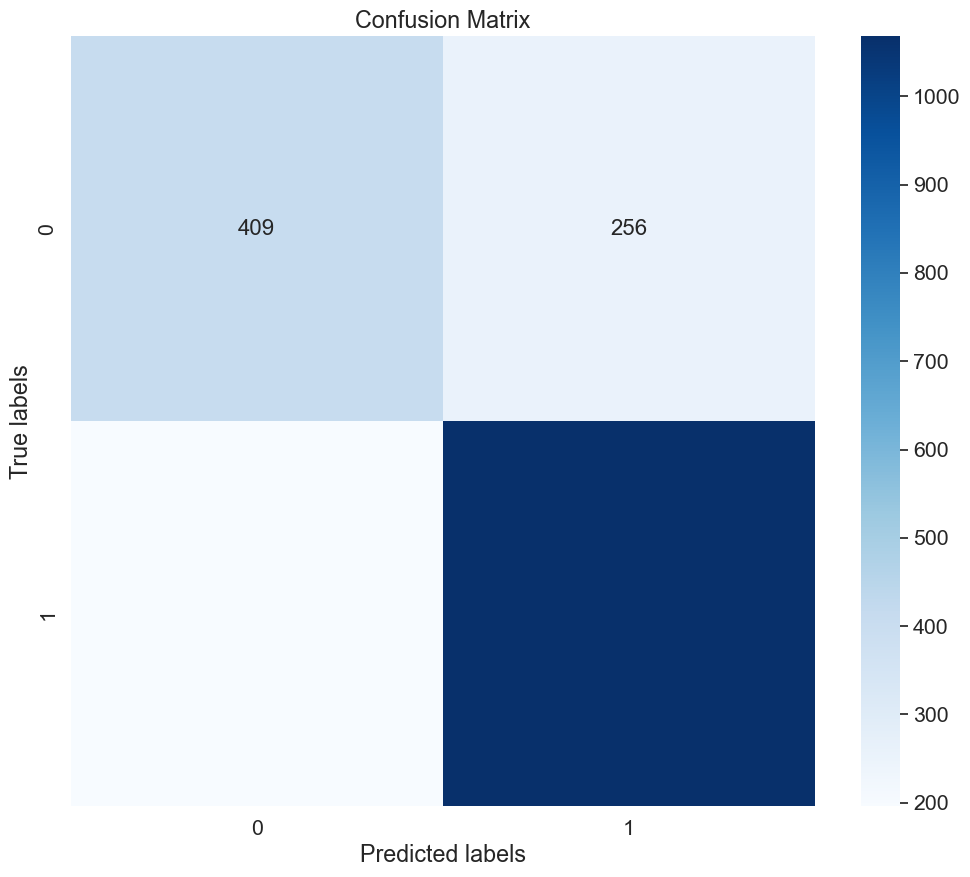

In [30]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
y_pred = (probabilities > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()